## Feature Engineering Deep Dive チュートリアル

- [1. データの読み込みと確認](#readData)
    - データのロードと内容確認
    - 型変換
- [2. ベースラインモデルの作成](#baseline)
    - AutoML
    - モデルパフォーマンスと変数重要度の確認
- [3. Feature Engineeringとそれを利用したモデルの作成](#FE)
    - Feature Engineeringの実施
        1. [代数変換(Algebraic Transformation)](#fe1)
        2. [Target Encoding](#fe2)
        3. [Combining Categories](#fe3)
        4. [Indicator Functions（指示変数への変換）](#fe4)
        5. [Separating Typical from Extreme（「典型」と「外れ」を示す変数を作成する）](#fe5)
    - Feature Engineeringによるモデルの精度変化の確認

In [1]:
import h2o
from h2o.automl import H2OAutoML

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

In [2]:
#> H2Oクラスターの開始
h2o.init(url='http://localhost:54321')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_261"; Java(TM) SE Runtime Environment (build 1.8.0_261-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from /home/ec2-user/anaconda3/envs/h2o_3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpeznnqr1_
  JVM stdout: /tmp/tmpeznnqr1_/h2o_ec2_user_started_from_python.out
  JVM stderr: /tmp/tmpeznnqr1_/h2o_ec2_user_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Tokyo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,1 month and 13 days
H2O_cluster_name:,H2O_from_python_ec2_user_l3ed8m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.399 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


***

<a id='readData'></a>
### 1. データの読み込みと確認

In [3]:
#> データのロード
loans = h2o.import_file("https://sample-data-open.s3-ap-northeast-1.amazonaws.com/h2o_sample_loan/loan.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
loans.head(5)

loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
5000,36 months,10.65,10,RENT,24000,credit_card,AZ,27.65,0,83.7,9,0,26,verified
2500,60 months,15.27,0,RENT,30000,car,GA,1,0,9.4,4,1,12,verified
2400,36 months,15.96,10,RENT,12252,small_business,IL,8.72,0,98.5,10,0,10,not verified
10000,36 months,13.49,10,RENT,49200,other,CA,20,0,21,37,0,15,verified
5000,36 months,7.9,3,RENT,36000,wedding,AZ,11.2,0,28.3,12,0,7,verified


In [5]:
loans.describe()

Rows:163987
Cols:15




,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
type,int,enum,real,int,enum,real,enum,enum,real,int,real,int,int,int,enum
mins,500.0,,5.42,0.0,,1896.0,,,0.0,0.0,0.0,1.0,0.0,0.0,
mean,13074.169141456336,,13.715904065566168,5.684352932995333,,71915.67051974915,,,15.881530121290089,0.2273570060625282,54.07917280242262,24.57973383427463,0.1830388994249544,14.854273655448353,
maxs,35000.0,,26.06,10.0,,7141778.0,,,39.99,29.0,150.70000000000002,118.0,1.0,65.0,
sigma,7993.556188734652,,4.3919398705457935,3.610663731100237,,59070.91565491827,,,7.587668224192549,0.694167922928418,25.285366766770515,11.685190365910659,0.3866995896078875,6.947732922546697,
zeros,0,,0,14248,,0,,,270,139459,1562,0,133971,11,
missing,0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0
0,5000.0,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,83.7,9.0,0.0,26.0,verified
1,2500.0,60 months,15.27,0.0,RENT,30000.0,car,GA,1.0,0.0,9.4,4.0,1.0,12.0,verified
2,2400.0,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0.0,10.0,not verified


#### データに関して

[LendingClub](https://www.lendingclub.com/info/statistics.action)データに対しデータクレンジングと簡素化を実施したもの

|Id  | Column Name | Description | 説明 |
|:---|:----------------------|:-------------------|:-------------------|
|1   | loan_amnt             | Requested loan amount (US dollars)       | 申し込まれたローンの額(USD) |
|2   | term                  | Loan term length (months)       | 申し込まれたローン期間(月) |
|3   | int_rate              | Recommended interest rate       | 貸出金利 |
|4   | emp_length            | Employment length (years)       | 継続雇用期間(年) |
|5   | home_ownership        | Housing status       | 住居形態 |
|6   | annual_inc            | Annual income (US dollars)       | 年収(USD) |
|7   | purpose               | Purpose for the loan       | ローン借り入れ理由 |
|8   | addr_state            | State of residence       | 居住州 |
|9   | dti                   | Debt to income ratio       | 負債比率(%)（既存のローンの返済額を借り手の月収で割った率） |
|10  | delinq_2yrs           | Number of delinquencies in the past 2 years       | 過去2年における滞納回数 |
|11  | revol_util            | Percent of revolving credit line utilized       | リボルビングクレジット利用率(%) |
|12  | total_acc             | Number of active accounts       | 与信枠数 |
|13  | bad_loan              | Bad loan indicator       | 不良貸し付け |
|14  | longest_credit_length | Age of oldest active account       | 最長の与信枠(年) |
|15  | verification_status   | Income verification status       | 所得確認状況 |

参考：[Lending Club Loan Analysis](https://www.kaggle.com/janiobachmann/lending-club-risk-analysis-and-metrics) on Kaggle Notebook

`bad_loan`をターゲットとしてモデル作成

In [6]:
#> int型をカテゴリ型(enum)へ変更
loans['bad_loan'] = loans['bad_loan'].asfactor()

In [7]:
loans['bad_loan'].describe()

Rows:163987
Cols:1




,bad_loan
type,enum
mins,
mean,
maxs,
sigma,
zeros,
missing,0
0,0
1,1
2,0


In [8]:
#> 水準数の確認（1:不良貸し付け）
loans['bad_loan'].table()

bad_loan,Count
0,133971
1,30016


In [9]:
#> 1:不良貸し付けの割合
loans['bad_loan'].table()[1,1]/loans.nrows

0.1830388994249544

In [10]:
#> 学習/テストデータセットへの分割（学習:テスト = 80%:20% ）
train, test = loans.split_frame([0.8], seed=12345)
print(">> train/testのデータ数")
print("train:%d test:%d" % (train.nrows, test.nrows))

>> train/testのデータ数
train:131248 test:32739


***

<a id='baseline'></a>
### 2. ベースラインモデルの作成

In [11]:
response = "bad_loan"   # ターゲット変数

predictors = train.col_names
predictors.remove(response)
predictors.remove("int_rate")
predictors   # 特徴量(13)

['loan_amnt',
 'term',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'verification_status']

In [12]:
aml = H2OAutoML(max_models = 6,
                max_runtime_secs_per_model = 60,
                exclude_algos = ['DRF', 'DeepLearning', 'StackedEnsemble'],
                seed = 12345)

%time aml.train(x = predictors, y = response, training_frame = train)

AutoML progress: |█████████
12:27:13.270: GLM_1_AutoML_20201017_122501 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException: 82

███████████████████████████████████████████████| 100%
CPU times: user 5.98 s, sys: 183 ms, total: 6.16 s
Wall time: 3min 48s


- max_models（作成する最大モデル数）かmax_runtime_secs（最大実行時間数）の設定に達すると、探索が終了（[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html#required-stopping-parameters)）
- [exclude_algos](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/exclude_algos.html)にしたアルゴリズムはAutoMLで試行されない

In [13]:
#> k分割交差検証法の分割数(k)
aml.nfolds

5

In [14]:
#> k分割交差検証法による結果。AUC順
aml.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_1_AutoML_20201017_122501,0.681176,0.443732,0.319553,0.36962,0.373555,0.139544
XGBoost_3_AutoML_20201017_122501,0.679816,0.444138,0.318098,0.370936,0.373766,0.139701
GBM_2_AutoML_20201017_122501,0.679021,0.444618,0.315893,0.371141,0.374013,0.139886
GBM_3_AutoML_20201017_122501,0.676137,0.445671,0.313651,0.372875,0.374456,0.140217
XGBoost_1_AutoML_20201017_122501,0.660832,0.45526,0.297487,0.384246,0.378586,0.143327
XGBoost_2_AutoML_20201017_122501,0.644875,0.469242,0.282161,0.396835,0.38386,0.147349


並び順に関しての[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/sort_metric.html)

In [15]:
#> leaderboardの一番上のモデル
aml.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20201017_122501


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,52.0,52.0,47958.0,6.0,6.0,6.0,32.0,64.0,58.923077




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1330293974524767
RMSE: 0.3647319528811216
LogLoss: 0.4254314489578683
Mean Per-Class Error: 0.33645415118293
AUC: 0.7257812953735341
AUCPR: 0.40112712250300603
Gini: 0.45156259074706817

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21000410129532213: 


,,0,1,Error,Rate
0,0,80870.0,26438.0,0.2464,(26438.0/107308.0)
1,1,10368.0,13572.0,0.4331,(10368.0/23940.0)
2,Total,91238.0,40010.0,0.2804,(36806.0/131248.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.210004,0.424457,221.0
1,max f2,0.123976,0.569923,313.0
2,max f0point5,0.309659,0.414528,142.0
3,max accuracy,0.416478,0.825392,82.0
4,max precision,0.856613,1.000000,0.0
5,max recall,0.035840,1.000000,398.0
6,max specificity,0.856613,1.000000,0.0
7,max absolute_mcc,0.249072,0.271708,188.0
8,max min_per_class_accuracy,0.183263,0.661908,247.0
9,max mean_per_class_accuracy,0.185238,0.663546,245.0



Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.26 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.509204,4.096121,4.096121,0.747144,0.572163,0.747144,0.572163,0.040977,0.040977,309.612149,309.612149,0.037884
1,2,0.020000,0.457852,3.317838,3.707128,0.605183,0.480447,0.676190,0.526322,0.033166,0.074144,231.783829,270.712814,0.066223
2,3,0.030004,0.427133,2.918643,3.444233,0.532369,0.441654,0.628238,0.498093,0.029198,0.103342,191.864314,244.423306,0.089699
3,4,0.040001,0.403387,2.703579,3.259140,0.493140,0.414617,0.594476,0.477232,0.027026,0.130368,170.357856,225.913998,0.110527
4,5,0.050005,0.383508,2.534501,3.114168,0.462300,0.393153,0.568033,0.460411,0.025355,0.155723,153.450127,211.416807,0.129303
5,6,0.100002,0.320561,2.162204,2.638222,0.394392,0.348773,0.481219,0.404596,0.108104,0.263826,116.220364,163.822212,0.200373
6,7,0.150006,0.280387,1.761744,2.346048,0.321347,0.299464,0.427926,0.369550,0.088095,0.351921,76.174369,134.604780,0.246962
7,8,0.200003,0.251424,1.547296,2.146375,0.282231,0.265316,0.391505,0.343494,0.077360,0.429282,54.729565,114.637498,0.280430
8,9,0.300005,0.211053,1.315769,1.869506,0.240000,0.229988,0.341003,0.305658,0.131579,0.560860,31.576942,86.950646,0.319052
9,10,0.399998,0.181878,1.056873,1.666360,0.192777,0.195737,0.303949,0.278180,0.105681,0.666541,5.687311,66.635973,0.326008




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.13954355878848432
RMSE: 0.37355529548981675
LogLoss: 0.44373204240160347
Mean Per-Class Error: 0.36793432447933117
AUC: 0.6811763163001875
AUCPR: 0.3195529756610926
Gini: 0.362352632600375

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19121624842192197: 


,,0,1,Error,Rate
0,0,72998.0,34310.0,0.3197,(34310.0/107308.0)
1,1,10043.0,13897.0,0.4195,(10043.0/23940.0)
2,Total,83041.0,48207.0,0.3379,(44353.0/131248.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.191216,0.385241,235.0
1,max f2,0.113116,0.551538,321.0
2,max f0point5,0.275878,0.346527,160.0
3,max accuracy,0.536628,0.817971,33.0
4,max precision,0.834213,1.000000,0.0
5,max recall,0.034767,1.000000,397.0
6,max specificity,0.834213,1.000000,0.0
7,max absolute_mcc,0.198377,0.209207,228.0
8,max min_per_class_accuracy,0.178389,0.629616,247.0
9,max mean_per_class_accuracy,0.170065,0.632066,255.0



Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.22 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.504740,2.755800,2.755800,0.502666,0.563913,0.502666,0.563913,0.027569,0.027569,175.580039,175.580039,0.021484
1,2,0.020000,0.454920,2.569862,2.662867,0.468750,0.477531,0.485714,0.520739,0.025689,0.053258,156.986216,166.286669,0.040678
2,3,0.030004,0.424099,2.309027,2.544890,0.421173,0.438426,0.464195,0.493294,0.023099,0.076358,130.902669,154.489007,0.056695
3,4,0.040001,0.400737,2.202142,2.459236,0.401677,0.412039,0.448571,0.472988,0.022013,0.098371,120.214204,145.923571,0.071393
4,5,0.050005,0.381668,2.125307,2.392430,0.387662,0.391174,0.436386,0.456620,0.021261,0.119632,112.530667,139.242955,0.085162
5,6,0.100002,0.319052,1.905713,2.149090,0.347607,0.347000,0.392000,0.401814,0.095280,0.214912,90.571349,114.909006,0.140547
6,7,0.150006,0.279424,1.622241,1.973465,0.295901,0.297968,0.359965,0.367197,0.081119,0.296032,62.224099,97.346478,0.178603
7,8,0.200003,0.251198,1.494661,1.853773,0.272630,0.264785,0.338133,0.341596,0.074728,0.370760,49.466086,85.377292,0.208852
8,9,0.300005,0.211133,1.294884,1.667477,0.236190,0.230058,0.304152,0.304417,0.129490,0.500251,29.488419,66.747668,0.244920
9,10,0.399998,0.181879,1.131648,1.533527,0.206416,0.195970,0.279720,0.277307,0.113158,0.613409,13.164793,53.352715,0.261021




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.64853543,0.01507191,0.6656,0.64849526,0.6501333,0.65408206,0.62436664
1,auc,0.6811718,0.002338276,0.67988724,0.67933655,0.68495834,0.67976797,0.6819087
2,aucpr,0.31993786,0.004454398,0.31562677,0.317051,0.32592648,0.32335785,0.31772715
3,err,0.35146454,0.01507191,0.3344,0.35150477,0.34986666,0.34591794,0.37563336
4,err_count,9225.8,395.5189,8778.0,9227.0,9184.0,9080.0,9860.0
5,f0point5,0.31744868,0.0031922602,0.31710637,0.31528866,0.32086727,0.32044545,0.31353563
6,f1,0.38643736,0.0039812895,0.38104638,0.38400427,0.39098144,0.3869835,0.3891711
7,f2,0.49398082,0.013385564,0.47728395,0.4910196,0.5003055,0.48839507,0.51290005
8,lift_top_group,2.768916,0.2272048,2.9044082,2.699827,2.9355848,2.905773,2.3989859
9,logloss,0.44373208,0.0026912112,0.44009697,0.44331858,0.44253618,0.44680297,0.44590575



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-10-17 12:27:41,27.972 sec,0.0,0.386176,0.475017,0.500000,0.182403,1.000000,0.817597
1,,2020-10-17 12:27:41,28.404 sec,5.0,0.378506,0.456438,0.686677,0.341127,3.262721,0.318953
2,,2020-10-17 12:27:42,28.826 sec,10.0,0.374227,0.446749,0.694804,0.354703,3.557488,0.318534
3,,2020-10-17 12:27:42,29.215 sec,15.0,0.371776,0.441211,0.700571,0.362717,3.636821,0.317780
4,,2020-10-17 12:27:42,29.577 sec,20.0,0.370129,0.437519,0.704075,0.369115,3.787138,0.305567
5,,2020-10-17 12:27:43,29.945 sec,25.0,0.368869,0.434685,0.708773,0.375917,3.858121,0.308881
6,,2020-10-17 12:27:43,30.318 sec,30.0,0.367974,0.432619,0.712293,0.380881,3.866471,0.313963
7,,2020-10-17 12:27:43,30.685 sec,35.0,0.367114,0.430630,0.715874,0.385359,3.883173,0.305742
8,,2020-10-17 12:27:44,31.056 sec,40.0,0.366299,0.428829,0.719387,0.390594,3.991735,0.291517
9,,2020-10-17 12:27:44,31.457 sec,45.0,0.365549,0.427177,0.722818,0.395748,4.050191,0.282313



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,term,1979.081421,1.000000,0.200380
1,addr_state,1958.390137,0.989545,0.198285
2,annual_inc,1266.576294,0.639982,0.128240
3,revol_util,1105.296509,0.558490,0.111910
4,dti,896.081665,0.452777,0.090728
5,purpose,860.982361,0.435041,0.087174
6,loan_amnt,645.692688,0.326259,0.065376
7,longest_credit_length,256.834076,0.129774,0.026004
8,total_acc,235.710419,0.119101,0.023865
9,emp_length,232.263901,0.117359,0.023517


In [16]:
#> テストデータに対する結果の取得
perf = aml.leader.model_performance(test_data=test)
perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.14128182734644792
RMSE: 0.37587474954623906
LogLoss: 0.4478148716073599
Mean Per-Class Error: 0.364585167902983
AUC: 0.6834644287536212
AUCPR: 0.3227999011453459
Gini: 0.36692885750724247

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19705499862227122: 


,,0,1,Error,Rate
0,0,18841.0,7822.0,0.2934,(7822.0/26663.0)
1,1,2662.0,3414.0,0.4381,(2662.0/6076.0)
2,Total,21503.0,11236.0,0.3202,(10484.0/32739.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.197055,0.394409,222.0
1,max f2,0.106007,0.555690,328.0
2,max f0point5,0.253064,0.354823,172.0
3,max accuracy,0.509683,0.814930,36.0
4,max precision,0.822082,1.000000,0.0
5,max recall,0.038076,1.000000,395.0
6,max specificity,0.822082,1.000000,0.0
7,max absolute_mcc,0.211327,0.222425,208.0
8,max min_per_class_accuracy,0.177394,0.633575,243.0
9,max mean_per_class_accuracy,0.188128,0.635415,231.0



Gains/Lift Table: Avg response rate: 18.56 %, avg score: 18.16 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010019,0.500588,2.743407,2.743407,0.509146,0.556100,0.509146,0.556100,0.027485,0.027485,174.340719,174.340719,0.021447
1,2,0.020007,0.448509,2.109162,2.426769,0.391437,0.471218,0.450382,0.513723,0.021066,0.048552,110.916163,142.676857,0.035050
2,3,0.030025,0.420432,2.119159,2.324128,0.393293,0.434082,0.431333,0.487149,0.021231,0.069783,111.915885,132.412768,0.048817
3,4,0.040013,0.396846,2.438718,2.352732,0.452599,0.407985,0.436641,0.467389,0.024358,0.094141,143.871813,135.273156,0.066462
4,5,0.050002,0.379323,1.977339,2.277745,0.366972,0.387674,0.422724,0.451465,0.019750,0.113891,97.733903,127.774478,0.078448
5,6,0.100003,0.320736,1.925550,2.101647,0.357361,0.346815,0.390043,0.399140,0.096280,0.210171,92.555014,110.164746,0.135273
6,7,0.150005,0.279033,1.754390,1.985895,0.325596,0.298636,0.368560,0.365639,0.087722,0.297893,75.439013,98.589501,0.181590
7,8,0.200006,0.251191,1.579939,1.884406,0.293219,0.264659,0.349725,0.340394,0.078999,0.376893,57.993857,88.440590,0.217196
8,9,0.300009,0.210700,1.361051,1.709954,0.252596,0.229798,0.317349,0.303528,0.136109,0.513002,36.105125,70.995435,0.261530
9,10,0.400012,0.180722,1.066459,1.549080,0.197923,0.195004,0.287492,0.276397,0.106649,0.619651,6.645854,54.908040,0.269690


**各データセット、検証におけるAUCの比較**

In [17]:
print("AUC: train = {:.4f}, X-val = {:.4f}, test = {:.4f}".format(aml.leader.auc(train=True),
                                                                  aml.leader.auc(xval=True), 
                                                                  perf.auc()))

AUC: train = 0.7258, X-val = 0.6812, test = 0.6835


**変数重要度の確認**

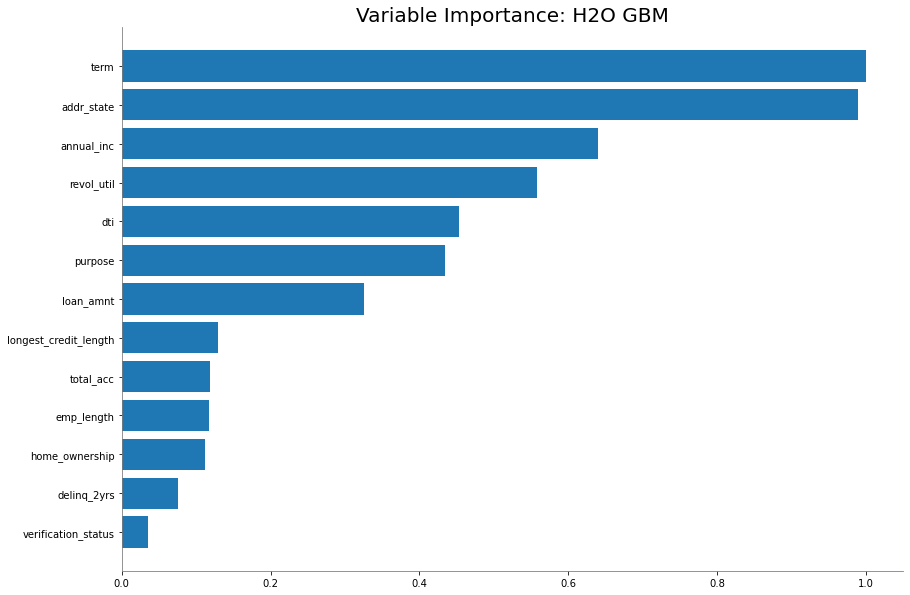

In [18]:
aml.leader.varimp_plot(13)

上位に入るaddr_stateは50水準、purposeは14水準のカテゴリカル変数

In [19]:
print( loans['addr_state'].table().dim[0] )
print( loans['purpose'].table().dim[0] )

50
14


***

<a id='FE'></a>
### 3. Feature Engineeringとそれを利用したモデルの作成

練習として、以下5つのFeature Engineeringをそれぞれの変数に実施する
1. **[代数変換(Algebraic Transformation)](#fe1)**
    - 年収(USD)(annual_inc)と与信枠数(total_acc)の比
<br><br>
2. **[Target Encoding](#fe2)**
    - 居住数(addr_state)
    - ローン借り入れ理由(purpose)
<br><br>
3. **[Combining Categories](#fe3)**
    - 住所形態(home_ownership)
<br><br>
4. **[Indicator Functions（指示変数への変換）](#fe4)**
    - 申し込まれたローン期間(月)(term)
    - 所得確認状況(verification_status)
    - 継続雇用期間(年)(emp_length) - 欠損を示すIndicator
<br><br>
5. **[Separating Typical from Extreme（「典型」と「外れ」を示す変数を作成する）](#fe5)**
    - 申し込まれたローンの額(USD)(loan_amnt)
    - リボルビングクレジット利用率(%)(revol_util)
    - 過去2年における滞納回数(delinq_2yrs)
    - 年収(USD)(annual_inc)
    - 負債比率(%)(dti)
    - 与信枠数(total_acc)
    - 最長の与信枠(年)(longest_credit_length)

<a id='fe1'></a>
#### 1. 代数変換(Algebraic Transformation)

与信枠数に対する年収を算出`annual_inc/total_acc`  
分布の歪みを整えるため、対数変換も実施

Probs,annual_incQuantiles
0.01,794.19
0.1,1400
0.25,1928.57
0.333,2189.45
0.5,2772.73
0.667,3529.41
0.75,4090.91
0.9,6000
0.99,13562.2


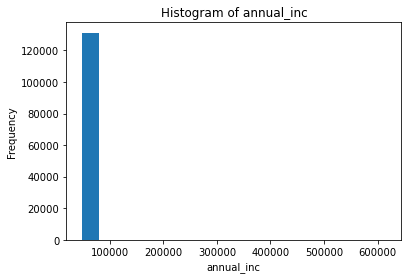

In [20]:
#> 対数変換しない場合
print( (train['annual_inc']/train['total_acc']).quantile() )
(train['annual_inc']/train['total_acc']).hist()

Probs,log(annual_inc)Quantiles
0.01,6.67732
0.1,7.24423
0.25,7.56453
0.333,7.69141
0.5,7.92759
0.667,8.16889
0.75,8.31652
0.9,8.69951
0.99,9.51504


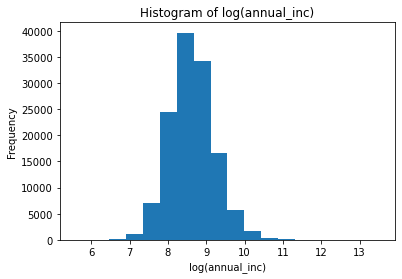

In [21]:
#> 対数変換した場合
print( (train['annual_inc'].log()-train['total_acc'].log()).quantile() )
(train['annual_inc'].log()-train['total_acc'].log()).hist()

In [22]:
transformed = predictors.copy()    # Feature Engineeringを加えた変数のリストtransformedとする

train['log_inc_per_acct'] = train['annual_inc'].log()-train['total_acc'].log()

transformed.append('log_inc_per_acct')
len(transformed)

14

In [23]:
#> testデータに対する処理
test['log_inc_per_acct'] = test['annual_inc'].log()-test['total_acc'].log()

<a id='fe2'></a>
#### 2. Target Encoding

多水準カテゴリカル変数(High-cardinality Categorical Variable)に対し、Cross Varidationを用いた平均値によるTarget Encodingを実施  
hold outデータの対象カテゴリカル変数（purpose, addr_state）の各カテゴリ水準を、その他のデータから計算したターゲット変数(bad_loan)の平均値で置き換える  
一般的に、One-hot Encodingを多水準カテゴリカル変数に実施した場合、オーバーフィッティングとなっている可能性が高い    

[参考リソース](https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/categorical-predictors/target_encoding.md)

以下の方法は、Target Encoding後のモデル学習においてTarget EncodingのCross Varidationを考慮していないので、厳密にはリークが起こっていることに注意

In [24]:
#> Target Encoding用のCross Varidation分割を示す変数の作成
cv_nfolds = 5
cv_seed = 12345
train["cv_fold"] = train.kfold_column(n_folds=cv_nfolds, seed=cv_seed)

train["cv_fold"].table()

cv_fold,Count
0,26201
1,26268
2,26424
3,26020
4,26335


In [25]:
#> cv_foldはマージキーとして扱うのでenum型にしておく
train["cv_fold"] = train["cv_fold"].asfactor()

### <span style="color: red; ">h2o.H2OFrame.mergeに関する注意点</span>  
  
<span style="color: red; ">マージキーが複数の場合、型を同じにしておく必要がある</span>  
異なっていると`Error: Merging columns must be the same type, ....`というエラーが出る  

マージキーが複数の場合、正しくマージできない現象に遭遇  
`train.merge(te_purpose, all_x=True, by_x=["purpose","cv_fold"], by_y=["purpose","cv_fold"])`を実行した際、train["te_purpose"]が全てnanになる現象に遭遇  
trainデータの中の変数順を入れ替えるとなぜか解決

In [26]:
def mean_target(data, x, y="bad_loan"):
    """
    xの水準別にyの平均値を算出する、確認のための関数
    """
    grouped_data = data[[x, y]].group_by([x])
    stats = grouped_data.count(na="ignore").mean(na="ignore")
    return stats.get_frame().as_data_frame()

def mean_target_encoding(data, x, y="bad_loan", fold_column="cv_fold"):
    """
    Creates target encoding for binary target
    クロスバリデーションTarget Encoding（x*fold_column別のyの平均値H2OFrameを算出）
    
    data (H2OFrame) : data set
    x (string) : categorical predictor column name
    y (string) : binary target column name
    fold_column (string) : cross-validation fold column name
    """ 
    nfold = int(data[fold_column].max()) + 1
    for j in range(0, nfold):     # k fold別の処理
        oof = data[data[fold_column] == str(j), [x, fold_column, y]]    # out of foldデータ
        other = data[data[fold_column] != str(j), [x, fold_column, y]]  # out of fole以外のデータ
        
        other_mean = other[[x, y]].group_by([x]).mean(na="ignore").get_frame()  # 以外のデータで、xの水準別平均の取得
        oof_res = oof.group_by([x, fold_column]).get_frame()
        oof_res = oof_res.merge(other_mean, all_x=True, by_x=[x], by_y=[x])    # x*fold_columnのdataframe
        
        if j==0:
            res = h2o.deep_copy(oof_res, "te_res")
        else:
            res = res.concat(oof_res, axis=0)     # 行の積み重ね
        
    res = res.rename(columns={"mean_{}".format(y): "te_{}".format(x)})  # target encoding後のカラムを「te_x」に変更。xは指定したカラム
    return res

- ローン借り入れ理由(purpose)に対しするTarget Encoding

In [27]:
#> ローン借り入れ理由(purpose)に対しての水準数の集計
tbl = train["purpose"].table().as_data_frame()    # 水準数の集計とPandas DFへの変換
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by="Count", ascending=0)
tbl = tbl.reset_index(drop=True)
tbl

,purpose,Count,Percent
0,debt_consolidation,74560,56.81
1,credit_card,24713,18.83
2,other,8416,6.41
3,home_improvement,7940,6.05
4,major_purchase,3750,2.86
5,small_business,3069,2.34
6,car,2280,1.74
7,medical,1626,1.24
8,wedding,1409,1.07
9,moving,1165,0.89


In [28]:
#> purposeの水準別のbad_loanの平均値の確認
df = mean_target(data=train, x="purpose", y="bad_loan")
print(df.shape)
df

(14, 3)


,purpose,nrow,mean_bad_loan
0,car,2280,0.126316
1,credit_card,24713,0.157528
2,debt_consolidation,74560,0.188560
3,educational,312,0.211538
4,home_improvement,7940,0.153149
5,house,990,0.182828
6,major_purchase,3750,0.136000
7,medical,1626,0.197417
8,moving,1165,0.205150
9,other,8416,0.213641


In [29]:
#> purposeに対してクロスバリデーションTarget Encodingの実施
te_purpose = mean_target_encoding(data=train, x="purpose", y="bad_loan", fold_column="cv_fold")
print( te_purpose.shape )
te_purpose

(70, 3)


purpose,cv_fold,te_purpose
car,0,0.131202
credit_card,0,0.157265
debt_consolidation,0,0.18941
educational,0,0.220833
home_improvement,0,0.151897
house,0,0.187811
major_purchase,0,0.136667
medical,0,0.202169
moving,0,0.206452
other,0,0.217028


In [30]:
#te_purpose.head(70)

In [31]:
#train.col_names

In [32]:
#> Target Encode結果をtrainへマージ
print(train.dim)
col = ['purpose','cv_fold',    # 注：キーを連続して配置
       'loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership', 'annual_inc', 'addr_state', 'dti',
       'delinq_2yrs', 'revol_util', 'total_acc', 'bad_loan', 
       'longest_credit_length', 'verification_status', 'log_inc_per_acct']    # 本来この処理は必要であるべきではない
train = train[col].merge(te_purpose, all_x=True, by_x=["purpose","cv_fold"], by_y=["purpose","cv_fold"])
print(train.dim)

[131248, 17]
[131248, 18]


In [33]:
train.head(5)    # te_purposeがnanとなっていない

purpose,cv_fold,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status,log_inc_per_acct,te_purpose
car,0,4500,60 months,10.65,0,MORTGAGE,42000,TX,5.4,0,78.3,9,0,28,verified,8.4482,0.131202
car,0,3500,36 months,6.03,10,MORTGAGE,83000,IL,2.31,0,13.4,28,0,25,verified,7.99439,0.131202
car,0,6000,36 months,14.27,10,MORTGAGE,94800,TX,24.53,0,95.9,30,0,25,verified,8.05833,0.131202
car,0,5600,36 months,6.03,nan,OWN,41100,NY,3.97,0,2.7,44,0,21,not verified,6.83957,0.131202
car,0,12000,36 months,12.42,0,RENT,60000,RI,6.3,0,78.7,14,1,6,verified,8.36304,0.131202


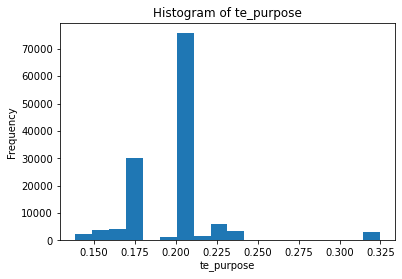

In [34]:
train["te_purpose"].hist()

In [35]:
#> Feature Engineeringを加えた変数のリストtransformedへ、te_purposeを追加し、purposeを削除
transformed.remove("purpose")
transformed.append("te_purpose")
print(len(transformed))
transformed

14


['loan_amnt',
 'term',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'verification_status',
 'log_inc_per_acct',
 'te_purpose']

In [36]:
#> testデータに対する処理 - trainデータ全体の集計値を利用
te_for_test = h2o.H2OFrame.from_python(df).drop("nrow").rename(columns={"mean_bad_loan":"te_purpose"})  # 上で集計済みのdf
te_for_test["purpose"] = te_for_test["purpose"].asfactor()    # string型なのでenum型に変更
print(test.dim)
test = test.merge(te_for_test, all_x=True, by_x=["purpose"], by_y=["purpose"])
print(test.dim)

Parse progress: |█████████████████████████████████████████████████████████| 100%
[32739, 16]
[32739, 17]


- 居住数(addr_state)に対しするTarget Encoding

In [37]:
#> 水準数の集計
tbl = train["addr_state"].table().as_data_frame()
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
tbl

,addr_state,Count,Percent
0,CA,22897,17.45
1,NY,11514,8.77
2,TX,9612,7.32
3,FL,9061,6.90
4,NJ,5154,3.93
5,IL,4855,3.70
6,PA,4401,3.35
7,VA,4259,3.25
8,GA,4159,3.17
9,OH,3932,3.00


In [38]:
#> 準別のbad_loanの平均値の確認
df = mean_target(train, "addr_state")
print(df.shape)
df

(50, 3)


,addr_state,nrow,mean_bad_loan
0,AK,334,0.161677
1,AL,1580,0.215190
2,AR,887,0.191657
3,AZ,3152,0.174810
4,CA,22897,0.177840
5,CO,2837,0.141699
6,CT,2051,0.173574
7,DC,460,0.108696
8,DE,344,0.162791
9,FL,9061,0.211566


In [39]:
#> addr_stateに対してクロスバリデーションTarget Encodingの実施
te_addr_state = mean_target_encoding(data=train, x="addr_state", fold_column="cv_fold")
print( te_addr_state.shape )
te_addr_state

(245, 3)


addr_state,cv_fold,te_addr_state
AK,0,0.173745
AL,0,0.208661
AR,0,0.204138
AZ,0,0.173913
CA,0,0.17996
CO,0,0.144004
CT,0,0.163782
DC,0,0.0957746
DE,0,0.173285
FL,0,0.211244


In [40]:
#train.col_names

In [41]:
#> Target Encode結果をtrainへマージ
print(train.dim)
train = train.merge(te_addr_state, all_x=True, by_x=["addr_state","cv_fold"], by_y=["addr_state","cv_fold"])
print(train.dim)

[131248, 18]
[131248, 19]


In [42]:
train.head(5)

addr_state,cv_fold,purpose,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status,log_inc_per_acct,te_purpose,te_addr_state
AK,0,car,3500,36 months,5.42,nan,OWN,108000,0.81,0,3.3,25,0,41,not verified,8.37101,0.131202,0.173745
AK,0,car,7500,36 months,16.77,10,RENT,30000,13.72,0,78.9,15,0,8,not verified,7.6009,0.131202,0.173745
AK,0,credit_card,15000,60 months,17.06,1,OWN,45000,21.68,0,95.3,21,0,12,verified,7.6699,0.157265,0.173745
AK,0,credit_card,20000,36 months,13.67,3,MORTGAGE,75000,23.53,0,70.5,37,0,8,verified,7.61433,0.157265,0.173745
AK,0,credit_card,6950,36 months,14.33,4,RENT,38000,17.57,0,38.3,15,0,10,not verified,7.83729,0.157265,0.173745


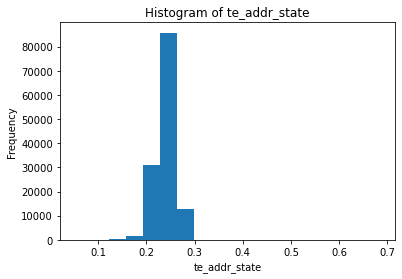

In [43]:
train["te_addr_state"].hist()

In [44]:
#> Feature Engineeringを加えた変数のリストtransformedへ、te_addr_stateを追加し、addr_stateを削除
transformed.remove("addr_state")
transformed.append("te_addr_state")
print(len(transformed))
transformed

14


['loan_amnt',
 'term',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'verification_status',
 'log_inc_per_acct',
 'te_purpose',
 'te_addr_state']

In [45]:
#> testデータに対する処理
te_for_test = h2o.H2OFrame.from_python(df).drop("nrow").rename(columns={"mean_bad_loan":"te_addr_state"})
te_for_test["addr_state"] = te_for_test["addr_state"].asfactor()    # string型なのでenum型に変更
print(test.dim)
test = test.merge(te_for_test, all_x=True, by_x=["addr_state"], by_y=["addr_state"])
print(test.dim)

Parse progress: |█████████████████████████████████████████████████████████| 100%
[32739, 17]
[32739, 18]


In [46]:
test.head(3)

addr_state,purpose,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status,log_inc_per_acct,te_purpose,te_addr_state
AK,credit_card,6200,36 months,10.65,10,MORTGAGE,24000,19.95,0,55.2,11,0,10,not verified,7.68791,0.157528,0.161677
AK,credit_card,10000,36 months,13.22,10,MORTGAGE,156000,14.57,2,17.4,31,0,19,not verified,8.52362,0.157528,0.161677
AK,credit_card,15000,60 months,15.61,9,RENT,60000,20.32,0,55.5,19,1,9,verified,8.05766,0.157528,0.161677


**現時点でのFeature Engineeringを用いて、精度向上や変化かがあるか確認してみる**

In [47]:
check = H2OAutoML(max_models = 4,
                  max_runtime_secs_per_model = 60,
                  include_algos = ['GBM'],
                  seed = 12345)

%time check.train(x = transformed, y = response, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%
CPU times: user 4.33 s, sys: 205 ms, total: 4.53 s
Wall time: 2min 22s


In [48]:
check.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_1_AutoML_20201017_122858,0.681368,0.443397,0.321341,0.367696,0.373355,0.139394
GBM_2_AutoML_20201017_122858,0.680143,0.443853,0.319809,0.3692,0.373554,0.139543
GBM_3_AutoML_20201017_122858,0.678653,0.44455,0.317018,0.371586,0.37391,0.139809
GBM_4_AutoML_20201017_122858,0.673281,0.446884,0.311656,0.375148,0.374901,0.140551


In [49]:
#> leaderboardの一番上のモデル
check.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20201017_122858


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,54.0,54.0,43224.0,6.0,6.0,6.0,32.0,64.0,59.333332




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13482937786429938
RMSE: 0.36719120069018457
LogLoss: 0.43065206600814065
Mean Per-Class Error: 0.3464682988892691
AUC: 0.7125820400207163
AUCPR: 0.3812653040448751
Gini: 0.4251640800414327

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20763228049167842: 


,,0,1,Error,Rate
0,0,79635.0,27673.0,0.2579,(27673.0/107308.0)
1,1,10588.0,13352.0,0.4423,(10588.0/23940.0)
2,Total,90223.0,41025.0,0.2915,(38261.0/131248.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.207632,0.411052,219.0
1,max f2,0.125498,0.563229,307.0
2,max f0point5,0.298343,0.394604,148.0
3,max accuracy,0.436010,0.823494,72.0
4,max precision,0.945146,1.000000,0.0
5,max recall,0.038102,1.000000,396.0
6,max specificity,0.945146,1.000000,0.0
7,max absolute_mcc,0.231631,0.253783,199.0
8,max min_per_class_accuracy,0.181375,0.651154,246.0
9,max mean_per_class_accuracy,0.192695,0.653532,234.0



Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.24 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.494933,3.916577,3.916577,0.714395,0.554480,0.714395,0.554480,0.039181,0.039181,291.657692,291.657692,0.035687
1,2,0.020000,0.450397,3.092192,3.504541,0.564024,0.471025,0.639238,0.512768,0.030911,0.070092,209.219186,250.454142,0.061267
2,3,0.030004,0.419655,2.755800,3.254898,0.502666,0.434112,0.593702,0.486543,0.027569,0.097661,175.580039,225.489770,0.082750
3,4,0.040001,0.398620,2.548969,3.078483,0.464939,0.408493,0.561524,0.467038,0.025480,0.123141,154.896897,207.848275,0.101689
4,5,0.050005,0.380727,2.388360,2.940416,0.435644,0.389402,0.536340,0.451506,0.023893,0.147034,138.836034,194.041620,0.118677
5,6,0.100002,0.318463,2.059440,2.499962,0.375648,0.346854,0.456000,0.399184,0.102966,0.250000,105.944048,149.996190,0.183463
6,7,0.150006,0.279594,1.711623,2.237169,0.312205,0.297877,0.408066,0.365413,0.085589,0.335589,71.162295,123.716891,0.226986
7,8,0.200003,0.251172,1.553979,2.066385,0.283450,0.264564,0.376914,0.340203,0.077694,0.413283,55.397943,106.638455,0.260862
8,9,0.300005,0.211139,1.295302,1.809357,0.236267,0.229895,0.330032,0.303433,0.129532,0.542815,29.530190,80.935700,0.296981
9,10,0.399998,0.182083,1.065228,1.623335,0.194301,0.196104,0.296101,0.276603,0.106516,0.649332,6.522784,62.333534,0.304958




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.13939427081049557
RMSE: 0.37335542156301355
LogLoss: 0.4433973647120642
Mean Per-Class Error: 0.3675410265889123
AUC: 0.6813682209010928
AUCPR: 0.3213408154494045
Gini: 0.36273644180218567

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18188234146768256: 


,,0,1,Error,Rate
0,0,69072.0,38236.0,0.3563,(38236.0/107308.0)
1,1,9075.0,14865.0,0.3791,(9075.0/23940.0)
2,Total,78147.0,53101.0,0.3605,(47311.0/131248.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.181882,0.385898,247.0
1,max f2,0.113015,0.551337,326.0
2,max f0point5,0.288977,0.347182,150.0
3,max accuracy,0.525915,0.818054,34.0
4,max precision,0.743526,0.818182,3.0
5,max recall,0.039380,1.000000,397.0
6,max specificity,0.826529,0.999981,0.0
7,max absolute_mcc,0.210274,0.209255,218.0
8,max min_per_class_accuracy,0.179259,0.631955,249.0
9,max mean_per_class_accuracy,0.179259,0.632459,249.0



Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.22 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.490238,2.793379,2.793379,0.509520,0.547599,0.509520,0.547599,0.027945,0.027945,179.337949,179.337949,0.021943
1,2,0.020000,0.448220,2.548969,2.671221,0.464939,0.467088,0.487238,0.507359,0.025480,0.053425,154.896897,167.122078,0.040882
2,3,0.030004,0.419298,2.380009,2.574126,0.434120,0.432709,0.469528,0.482469,0.023810,0.077235,138.000943,157.412568,0.057767
3,4,0.040001,0.397127,2.172892,2.473855,0.396341,0.407676,0.451238,0.463778,0.021721,0.098956,117.289158,147.385537,0.072108
4,5,0.050005,0.380161,2.200465,2.419161,0.401371,0.388376,0.441262,0.448693,0.022013,0.120969,120.046486,141.916060,0.086796
5,6,0.100002,0.318734,1.929942,2.174570,0.352027,0.346509,0.396648,0.397605,0.096491,0.217460,92.994220,117.457004,0.143663
6,7,0.150006,0.279453,1.597181,1.982097,0.291330,0.298118,0.361540,0.364441,0.079866,0.297327,59.718062,98.209712,0.180187
7,8,0.200003,0.251006,1.498838,1.861292,0.273392,0.264452,0.339505,0.339446,0.074937,0.372264,49.883823,86.129160,0.210692
8,9,0.300005,0.211345,1.304491,1.675692,0.237943,0.229970,0.305651,0.302954,0.130451,0.502715,30.449140,67.569154,0.247934
9,10,0.399998,0.182534,1.125382,1.538122,0.205273,0.196409,0.280558,0.276319,0.112531,0.615246,12.538188,53.812198,0.263269




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.63638306,0.011607241,0.62198097,0.6427429,0.6395429,0.6272239,0.6504248
1,auc,0.68138355,0.003915571,0.6793238,0.6869438,0.68349266,0.67684877,0.6803087
2,aucpr,0.32168132,0.002561078,0.322201,0.3259234,0.31984815,0.3206186,0.31981552
3,err,0.36361694,0.011607241,0.37801903,0.35725716,0.36045715,0.3727761,0.34957522
4,err_count,9544.8,304.72232,9923.0,9378.0,9462.0,9785.0,9176.0
5,f0point5,0.3141638,0.0035970707,0.31293932,0.31730688,0.31399187,0.30888465,0.3176963
6,f1,0.38654706,0.0031634897,0.3891659,0.38913497,0.38693792,0.38144004,0.38605648
7,f2,0.5023929,0.008279078,0.51448566,0.50299746,0.5040343,0.49854583,0.4919011
8,lift_top_group,2.7895572,0.07651785,2.6891782,2.777137,2.8915107,2.7579906,2.831969
9,logloss,0.4433974,0.0027985459,0.44601,0.44118455,0.43978646,0.44584274,0.44416317



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-10-17 12:29:29,30.611 sec,0.0,0.386176,0.475017,0.500000,0.182403,1.000000,0.817597
1,,2020-10-17 12:29:29,30.948 sec,5.0,0.379123,0.457894,0.675270,0.329578,3.263022,0.336264
2,,2020-10-17 12:29:29,31.356 sec,10.0,0.375638,0.449805,0.687014,0.341424,3.362856,0.351777
3,,2020-10-17 12:29:30,31.751 sec,15.0,0.373249,0.444401,0.691538,0.348460,3.377943,0.320012
4,,2020-10-17 12:29:30,32.144 sec,20.0,0.371779,0.441072,0.694208,0.353571,3.519909,0.324325
5,,2020-10-17 12:29:31,32.552 sec,25.0,0.370691,0.438575,0.698272,0.359269,3.557488,0.334314
6,,2020-10-17 12:29:31,32.950 sec,30.0,0.369810,0.436569,0.701431,0.364111,3.620120,0.332645
7,,2020-10-17 12:29:31,33.371 sec,35.0,0.369041,0.434821,0.704716,0.369261,3.691102,0.310077
8,,2020-10-17 12:29:32,33.771 sec,40.0,0.368480,0.433569,0.706949,0.372769,3.745383,0.324371
9,,2020-10-17 12:29:32,34.163 sec,45.0,0.368000,0.432454,0.708973,0.375841,3.820541,0.317833



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,term,1813.654053,1.000000,0.209517
1,annual_inc,1224.971069,0.675416,0.141511
2,revol_util,1141.500854,0.629393,0.131869
3,dti,950.238403,0.523936,0.109773
4,loan_amnt,687.281860,0.378949,0.079396
5,te_purpose,685.078979,0.377734,0.079142
6,longest_credit_length,355.390808,0.195953,0.041055
7,te_addr_state,353.395294,0.194853,0.040825
8,total_acc,327.626190,0.180644,0.037848
9,log_inc_per_acct,299.601562,0.165192,0.034611


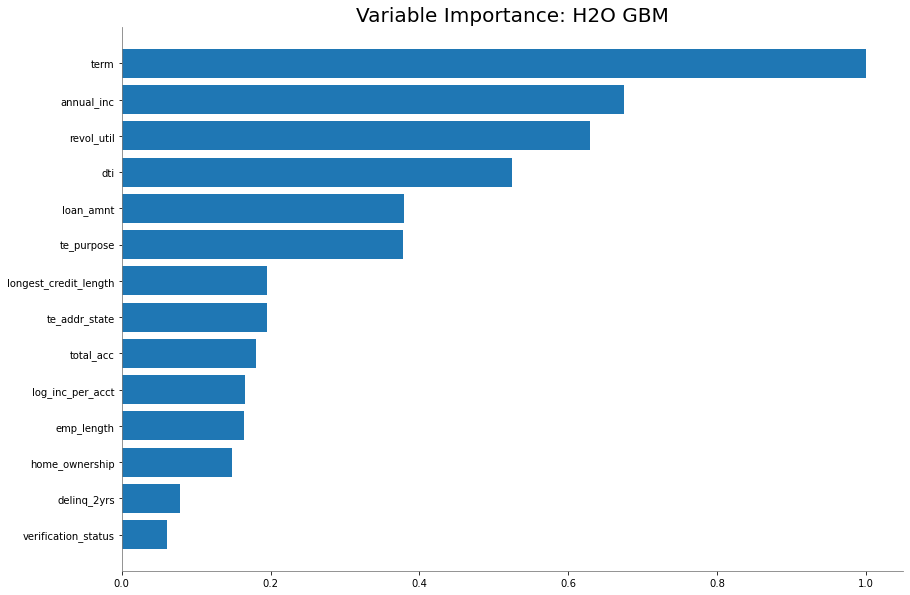

In [50]:
#> 変数重要度
check.leader.varimp_plot(14)

- log_inc_per_acctは11番目
- Target Encodingにより、addr_stateの重要度が低下した（Base Modelではオーバーフィッティング気味）

In [51]:
#> テストデータに対する結果の取得
perf2 = check.leader.model_performance(test_data=test)

In [52]:
print("--- AUC of Base Model ---")
print("AUC: train = {:.4f}, X-val = {:.4f}, test = {:.4f}".format(aml.leader.auc(train=True),
                                                                  aml.leader.auc(xval=True), 
                                                                  perf.auc()))
print("--- AUC of 中間 Model ---")
print("AUC: train = {:.4f}, X-val = {:.4f}, test = {:.4f}".format(check.leader.auc(train=True),
                                                                  check.leader.auc(xval=True), 
                                                                  perf2.auc()))

--- AUC of Base Model ---
AUC: train = 0.7258, X-val = 0.6812, test = 0.6835
--- AUC of 中間 Model ---
AUC: train = 0.7126, X-val = 0.6814, test = 0.6873


元々、H2OGradientBoostingEstimatorにおいて多水準カテゴリカル変数(High-cardinality Categorical Variable)の自動処理が組み込まれていることに注意（Target Encodingで、あまり精度が向上しない場合がある）  
H2OGradientBoostingEstimatorの[categorical_encoding引数に関して](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/categorical_encoding.html)

<a id='fe3'></a>
#### 3. Combining Categories

住所形態(home_ownership)は6水準のカテゴリカル変数だが、バランスの悪い構成となっている  
数の少ないANY,NONE,OTHERとRENTと結合して、OTHERカテゴリとする

In [53]:
#> home_ownership別での、bad_loanの平均割合
mean_target(train, "home_ownership")

,home_ownership,nrow,mean_bad_loan
0,ANY,1,0.000000
1,MORTGAGE,63757,0.163496
2,NONE,27,0.259259
3,OTHER,116,0.250000
4,OWN,10903,0.186004
5,RENT,56444,0.202891


In [54]:
lvls = ["OTHER", "MORTGAGE", "OTHER", "OTHER", "OWN", "OTHER"]
train["home_ownership_3cat"] = train["home_ownership"].set_levels(lvls).ascharacter().asfactor()
train[["home_ownership", "home_ownership_3cat"]].table()

transformed.remove("home_ownership")
transformed.append("home_ownership_3cat")
print( len(transformed) )

mean_target(train, "home_ownership_3cat")

14


,home_ownership_3cat,nrow,mean_bad_loan
0,MORTGAGE,63757,0.163496
1,OTHER,56588,0.203011
2,OWN,10903,0.186004


In [55]:
#> testデータに対する処理
test["home_ownership_3cat"] = test["home_ownership"].set_levels(lvls).ascharacter().asfactor()
test.dim

[32739, 19]

<a id='fe4'></a>
#### 4. Indicator Functions

- ローン期間(term)を5年を示す場合に1、3年を0に変換

In [56]:
train["term"].table()

term,Count
36 months,104026
60 months,27222


In [57]:
#> 60 months->1, 36 months -> 0 へ変換
train["term_60months"] = (train["term"] == "60 months")
train["term_60months"].table()

term_60months,Count
0,104026
1,27222


In [58]:
#> 変数名の置き換え
transformed.remove("term")
transformed.append("term_60months")
transformed

['loan_amnt',
 'emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'verification_status',
 'log_inc_per_acct',
 'te_purpose',
 'te_addr_state',
 'home_ownership_3cat',
 'term_60months']

In [59]:
#> testデータに対する処理
test["term_60months"] = (test["term"] == "60 months")
test.dim

[32739, 20]

- 所得確認状況(verification_status)をverifiedの場合1に、not varifiedの場合に0に変換

In [60]:
train["verification_status"].table()

verification_status,Count
not verified,47286
verified,83962


In [61]:
train["verified"] = (train["verification_status"] == "verified")
train["verified"].table()

verified,Count
0,47286
1,83962


In [62]:
transformed.remove("verification_status")
transformed.append("verified")
transformed

['loan_amnt',
 'emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'log_inc_per_acct',
 'te_purpose',
 'te_addr_state',
 'home_ownership_3cat',
 'term_60months',
 'verified']

In [63]:
#> testデータに対する処理
test["verified"] = (test["verification_status"] == "verified")
test.dim

[32739, 21]

- 継続雇用期間(年)(emp_length)が欠損を示す新しい変数（欠損だと1）を作成

In [64]:
train["emp_length"].summary()

,emp_length
type,int
mins,0.0
mean,5.6808450125614245
maxs,10.0
sigma,3.608577939766145
zeros,11391
missing,4670
0,nan
1,10.0
2,1.0


In [65]:
#> 欠損の割合
train["emp_length"].isna().sum() / train.nrows

0.03558149457515543

In [66]:
#> emp_lengthが欠損(nan)だと1となる変数(emp_length_missing)を作成
train["emp_length_missing"] = (train["emp_length"] == None)
train["emp_length_missing"].table()

emp_length_missing,Count
0,126578
1,4670


In [67]:
#> 変数名の追加
transformed.append("emp_length_missing")
transformed

['loan_amnt',
 'emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'log_inc_per_acct',
 'te_purpose',
 'te_addr_state',
 'home_ownership_3cat',
 'term_60months',
 'verified',
 'emp_length_missing']

In [68]:
#> emp_lengthの水準別にbad_loanの割合を確認してみる
df = mean_target(train, "emp_length")
df.drop(df.index[:1], inplace=True)   # remove NaN
df

,emp_length,nrow,mean_bad_loan
1,0.0,11391,0.183127
2,1.0,9056,0.178666
3,2.0,12712,0.171413
4,3.0,10930,0.178957
5,4.0,8825,0.171671
6,5.0,9910,0.180424
7,6.0,8035,0.186808
8,7.0,7259,0.190384
9,8.0,5901,0.182342
10,9.0,4871,0.185178


In [69]:
#> emp_length_missingの水準別にbad_loanの割合を確認してみる
mean_target(train, "emp_length_missing")

,emp_length_missing,nrow,mean_bad_loan
0,0,126578,0.179494
1,1,4670,0.261242


欠損か否かで大きくbad_loanの割合が異なっている

In [70]:
#> testデータに対する処理
test["emp_length_missing"] = (test["emp_length"] == None)

In [71]:
test.dim

[32739, 22]

<a id='fe5'></a>
#### 5. Separating Typical from Extreme

極端な値を含む変数から、それを考慮した新しい変数を作成することにより精度向上につながることがある  
ここでは、「典型」と「外れ」を示す変数を作成して行く

- ローン額(loan_amnt)に対し、変数変換を実施

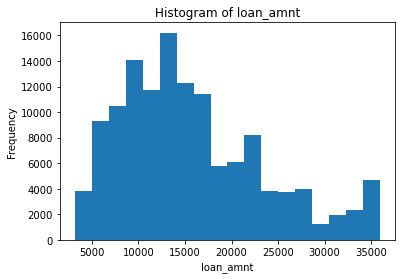

In [72]:
train["loan_amnt"].hist()

In [73]:
train["loan_amnt"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,loan_amntQuantiles
0,500
0.05,3000
0.25,7000
0.5,11325
0.75,18000
0.95,30000
1,35000


In [74]:
#> 0から35000の間を等間隔に分け、8つの閾値を作成（7つの区間）
breaks = np.linspace(0, 35000, 8).tolist()
breaks

[0.0, 5000.0, 10000.0, 15000.0, 20000.0, 25000.0, 30000.0, 35000.0]

In [75]:
#> loan_amountを7つの区間に分けたカテゴリ変数（loan_amnt_cat）を作成
train["loan_amnt_cat"] = train["loan_amnt"].cut(breaks = breaks)
train[["loan_amnt_cat","loan_amnt"]]

loan_amnt_cat,loan_amnt
"(0.0,5000.0]",3500
"(5000.0,10000.0]",7500
"(10000.0,15000.0]",15000
"(15000.0,20000.0]",20000
"(5000.0,10000.0]",6950
"(30000.0,35000.0]",35000
"(5000.0,10000.0]",10000
"(10000.0,15000.0]",10400
"(15000.0,20000.0]",20000
"(10000.0,15000.0]",13000


In [76]:
mean_target(train, "loan_amnt_cat")

,loan_amnt_cat,nrow,mean_bad_loan
0,"(0.0,5000.0]",20634,0.164050
1,"(5000.0,10000.0]",40364,0.162397
2,"(10000.0,15000.0]",28359,0.172785
3,"(15000.0,20000.0]",19727,0.208800
4,"(20000.0,25000.0]",11572,0.212323
5,"(25000.0,30000.0]",5565,0.240611
6,"(30000.0,35000.0]",5027,0.235727


loan_amntが5000から30000までbad_loanが増えていっており、5000より下と、30000より上はフラットになっている

In [77]:
#> 5000より下と、30000より上のloan_amntはそれぞれ5000と30000に置き換える新しい変数（loan_amnt_core）を作成
train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt"] <= 5000, 5000, train["loan_amnt"])
train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt_core"] <= 30000, train["loan_amnt_core"], 30000)
train[["loan_amnt","loan_amnt_core"]]

loan_amnt,loan_amnt_core
3500,5000
7500,7500
15000,15000
20000,20000
6950,6950
35000,30000
10000,10000
10400,10400
20000,20000
13000,13000


In [78]:
#> 置き換えを示す情報を持つ変数（loan_amnt_diff）を作成しておく
train["loan_amnt_diff"] = train["loan_amnt"] - train["loan_amnt_core"]
train[["loan_amnt","loan_amnt_core","loan_amnt_diff"]]

loan_amnt,loan_amnt_core,loan_amnt_diff
3500,5000,-1500
7500,7500,0
15000,15000,0
20000,20000,0
6950,6950,0
35000,30000,5000
10000,10000,0
10400,10400,0
20000,20000,0
13000,13000,0


In [79]:
#> 変数名の削除と追加
transformed.remove("loan_amnt")
transformed.append("loan_amnt_core")
transformed.append("loan_amnt_diff")
transformed

['emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'log_inc_per_acct',
 'te_purpose',
 'te_addr_state',
 'home_ownership_3cat',
 'term_60months',
 'verified',
 'emp_length_missing',
 'loan_amnt_core',
 'loan_amnt_diff']

In [80]:
#> testデータに対する処理
test["loan_amnt_core"] = h2o.H2OFrame.ifelse(test["loan_amnt"] <= 5000, 5000, test["loan_amnt"])
test["loan_amnt_core"] = h2o.H2OFrame.ifelse(test["loan_amnt_core"] <= 30000, test["loan_amnt_core"], 30000)
test["loan_amnt_diff"] = test["loan_amnt"] - test["loan_amnt_core"]
test.dim

[32739, 24]

- リボルビングクレジット利用率(%)(revol_util)に対する変数変換の実施

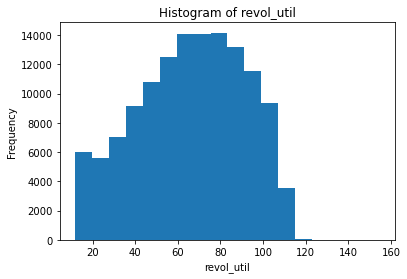

In [81]:
train["revol_util"].hist()

In [82]:
train["revol_util"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,revol_utilQuantiles
0,0
0.05,8.7
0.25,35.6
0.5,55.8
0.75,74.3
0.95,92.5
1,150.7


In [83]:
#> 欠損数
train["revol_util"].isna().sum()

145.0

In [84]:
#> カテゴリ化してbad_loanの傾向を確認
breaks = np.linspace(0, 120, 25).tolist()    # 0から120の間を等間隔に分け、25つの閾値を作成（24つの区間）
train["revol_util_cat"] = train["revol_util"].cut(breaks = breaks)

df = mean_target(train, "revol_util_cat")
df.drop(df.index[:1], inplace=True)   # remove NaN

df

,revol_util_cat,nrow,mean_bad_loan
1,"(0.0,5.0]",3005,0.102496
2,"(5.0,10.0]",3220,0.096273
3,"(10.0,15.0]",3485,0.105022
4,"(15.0,20.0]",4185,0.115412
5,"(20.0,25.0]",4848,0.127475
6,"(25.0,30.0]",5675,0.142907
7,"(30.0,35.0]",6383,0.153063
8,"(35.0,40.0]",7090,0.152045
9,"(40.0,45.0]",7780,0.157584
10,"(45.0,50.0]",8555,0.177089


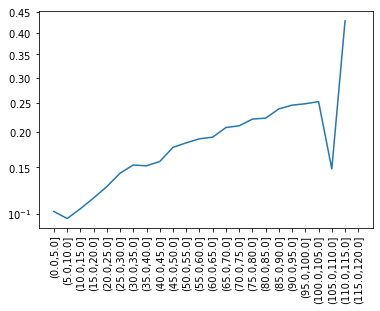

In [85]:
plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["revol_util_cat"], df["mean_bad_loan"])

In [86]:
#> revol_utilが0のbad_loanの割合
train[["revol_util","bad_loan"]][train["revol_util"]==0].group_by("revol_util").count().mean().get_frame()

revol_util,nrow,mean_bad_loan
0,1244,0.159968


以下3つの特徴を変数化する  
(a)revol_utilが0%だとややbad_loanが高くなる -> 指示変数の作成  
(b)その後、100%付近までbad_loanが上昇していく -> 「典型」  
(c)100%を超えるとイレギュラーな動き -> 「外れ」

In [87]:
train["revol_util_0"] = (train["revol_util"] == 0)   # (a)
train["revol_util_core"] = h2o.H2OFrame.ifelse(train["revol_util"] <= 100, train["revol_util"], 100)   # (b)
train["revol_util_diff"] = train["revol_util"] - train["revol_util_core"]   # (c)

In [88]:
#> 変数名の削除と追加
transformed.remove("revol_util")
transformed.append("revol_util_0")
transformed.append("revol_util_core")
transformed.append("revol_util_diff")
transformed

['emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'total_acc',
 'longest_credit_length',
 'log_inc_per_acct',
 'te_purpose',
 'te_addr_state',
 'home_ownership_3cat',
 'term_60months',
 'verified',
 'emp_length_missing',
 'loan_amnt_core',
 'loan_amnt_diff',
 'revol_util_0',
 'revol_util_core',
 'revol_util_diff']

In [89]:
#> testデータに対する処理
test["revol_util_0"] = (test["revol_util"] == 0)   # (a)
test["revol_util_core"] = h2o.H2OFrame.ifelse(test["revol_util"] <= 100, test["revol_util"], 100)   # (b)
test["revol_util_diff"] = test["revol_util"] - test["revol_util_core"]   # (c)
test.dim

[32739, 27]

以下の変数に対し同様に分析を行い、新しい変数（「典型」と「外れ」を示す）を作成する  

過去2年における滞納回数(delinq_2yrs)
- delinq_2yrs_core = min(delinq_2yrs, 3)
- delinq_2yrs_diff = delinq_2yrs − delinq_2yrs_core

年収(USD)(annual_inc)
- annual_inc_core = max(10000, min(annual_inc, 105000))
- annual_inc_diff = annual_inc - annual_inc_core

負債比率(%)(dti)
- dti_core = max(5, min(dti, 30))
- dti_diff = dti − dti_core

与信枠数(total_acc)
- total_acc_core = min(total_acc, 50)
- total_acc_diff = total_acc − total_acc_core

最長の与信枠(年)(longest_credit_length)
- longest_credit_length_core = max(3, min(longest_credit_length, 20))
- longest_credit_length_diff = longest_credit_length − longest_credit_length_core

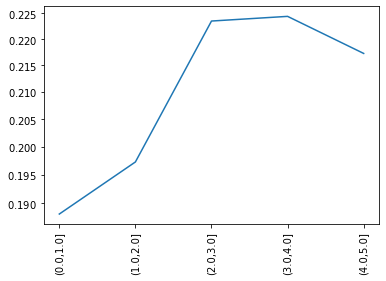

In [90]:
#> delinq_2yrs
train["delinq_2yrs"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

breaks = np.linspace(0, 5, 6).tolist()
train["delinq_2yrs_cat"] = train["delinq_2yrs"].cut(breaks = breaks)

df = mean_target(train, "delinq_2yrs_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["delinq_2yrs_cat"], df["mean_bad_loan"])

transformed.remove("delinq_2yrs")
transformed.append("delinq_2yrs_core")
transformed.append("delinq_2yrs_diff")

train["delinq_2yrs_core"] = h2o.H2OFrame.ifelse(train["delinq_2yrs"] <= 3, train["delinq_2yrs"], 3)
train["delinq_2yrs_diff"] = train["delinq_2yrs"] - train["delinq_2yrs_core"]

In [91]:
#> testデータに対する処理
test["delinq_2yrs_core"] = h2o.H2OFrame.ifelse(test["delinq_2yrs"] <= 3, test["delinq_2yrs"], 3)
test["delinq_2yrs_diff"] = test["delinq_2yrs"] - test["delinq_2yrs_core"]
test.dim

[32739, 29]

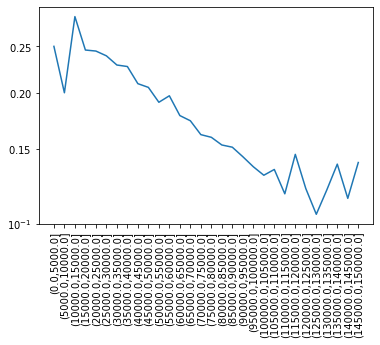

In [92]:
#> annual_inc
train["annual_inc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

breaks = np.linspace(0, 150000, 31).tolist()
train["annual_inc_cat"] = train["annual_inc"].cut(breaks = breaks)

df = mean_target(train, "annual_inc_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["annual_inc_cat"], df["mean_bad_loan"])

transformed.remove("annual_inc")
transformed.append("annual_inc_core")
transformed.append("annual_inc_diff")

train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc"] <= 10000, 10000, train["annual_inc"])
train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc_core"] <= 105000,
                                               train["annual_inc_core"], 105000)

train["annual_inc_diff"] = train["annual_inc"] - train["annual_inc_core"]

In [93]:
#> testデータに対する処理
test["annual_inc_core"] = h2o.H2OFrame.ifelse(test["annual_inc"] <= 10000, 10000, test["annual_inc"])
test["annual_inc_core"] = h2o.H2OFrame.ifelse(test["annual_inc_core"] <= 105000,
                                               test["annual_inc_core"], 105000)
test["annual_inc_diff"] = test["annual_inc"] - test["annual_inc_core"]
test.dim

[32739, 31]

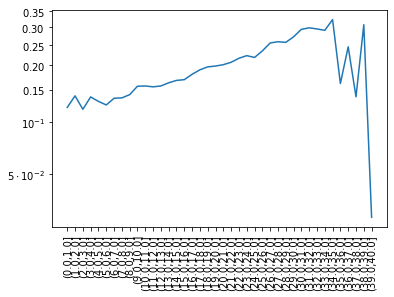

In [94]:
#> dti
train["dti"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

breaks = np.linspace(0, 40, 41).tolist()
train["dti_cat"] = train["dti"].cut(breaks = breaks)

df = mean_target(train, "dti_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["dti_cat"], df["mean_bad_loan"])

transformed.remove("dti")
transformed.append("dti_core")
transformed.append("dti_diff")

train["dti_core"] = h2o.H2OFrame.ifelse(train["dti"] <= 5, 5, train["dti"])
train["dti_core"] = h2o.H2OFrame.ifelse(train["dti_core"] <= 30, train["dti_core"], 30)

train["dti_diff"] = train["dti"] - train["dti_core"]

In [95]:
#> testデータに対する処理
test["dti_core"] = h2o.H2OFrame.ifelse(test["dti"] <= 5, 5, test["dti"])
test["dti_core"] = h2o.H2OFrame.ifelse(test["dti_core"] <= 30, test["dti_core"], 30)
test["dti_diff"] = test["dti"] - test["dti_core"]
test.dim

[32739, 33]

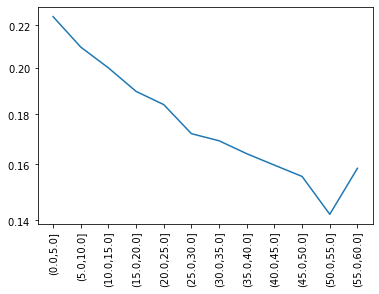

In [96]:
#> total_acc
train["total_acc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

breaks = np.linspace(0, 60, 13).tolist()
train["total_acc_cat"] = train["total_acc"].cut(breaks = breaks)

df = mean_target(train, "total_acc_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["total_acc_cat"], df["mean_bad_loan"])

(train["total_acc"] == None).table()

transformed.remove("total_acc")
transformed.append("total_acc_core")
transformed.append("total_acc_diff")

train["total_acc_core"] = h2o.H2OFrame.ifelse(train["total_acc"] <= 50, train["total_acc"], 50)
train["total_acc_diff"] = train["total_acc"] - train["total_acc_core"]

In [97]:
#> testデータに対する処理
test["total_acc_core"] = h2o.H2OFrame.ifelse(test["total_acc"] <= 50, test["total_acc"], 50)
test["total_acc_diff"] = test["total_acc"] - test["total_acc_core"]
test.dim

[32739, 35]

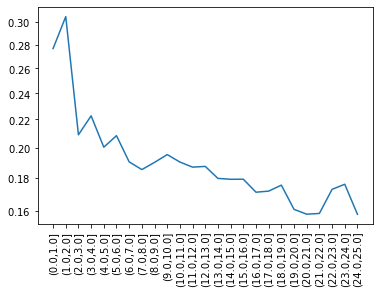

In [98]:
#> longest_credit_length
train["longest_credit_length"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

breaks = np.linspace(0, 25, 26).tolist()
train["longest_credit_length_cat"] = train["longest_credit_length"].cut(breaks = breaks)

df = mean_target(train, "longest_credit_length_cat")
df.drop(df.index[:1], inplace=True) # remove NaN

plt.yscale("logit")
plt.xticks(rotation = 90)
plt.plot(df["longest_credit_length_cat"], df["mean_bad_loan"])

transformed.remove("longest_credit_length")
transformed.append("longest_credit_length_core")
transformed.append("longest_credit_length_diff")

train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length"] <= 3,
                                                          3, train["longest_credit_length"])
train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length_core"] <= 20,
                                                          train["longest_credit_length_core"], 20)
train["longest_credit_length_diff"] = train["longest_credit_length"] - train["longest_credit_length_core"]

In [99]:
#> testデータに対する処理
test["longest_credit_length_core"] = h2o.H2OFrame.ifelse(test["longest_credit_length"] <= 3,
                                                          3, test["longest_credit_length"])
test["longest_credit_length_core"] = h2o.H2OFrame.ifelse(test["longest_credit_length_core"] <= 20,
                                                          test["longest_credit_length_core"], 20)
test["longest_credit_length_diff"] = test["longest_credit_length"] - test["longest_credit_length_core"]
test.dim

[32739, 37]

In [100]:
#> 最終的なモデルに利用する変数リスト
print(len(transformed))
transformed

23


['emp_length',
 'log_inc_per_acct',
 'te_purpose',
 'te_addr_state',
 'home_ownership_3cat',
 'term_60months',
 'verified',
 'emp_length_missing',
 'loan_amnt_core',
 'loan_amnt_diff',
 'revol_util_0',
 'revol_util_core',
 'revol_util_diff',
 'delinq_2yrs_core',
 'delinq_2yrs_diff',
 'annual_inc_core',
 'annual_inc_diff',
 'dti_core',
 'dti_diff',
 'total_acc_core',
 'total_acc_diff',
 'longest_credit_length_core',
 'longest_credit_length_diff']

**すべてのFeature Engineering結果を用いて、最終的なモデルを作成してみる**

In [101]:
final = H2OAutoML(max_models = 4,
                  max_runtime_secs_per_model = 60,
                  include_algos = ['GBM'],
                  seed = 12345)

%time final.train(x = transformed, y = response, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%
CPU times: user 5.28 s, sys: 212 ms, total: 5.49 s
Wall time: 3min 1s


In [102]:
final.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_1_AutoML_20201017_123131,0.681385,0.443483,0.320916,0.367651,0.373379,0.139412
GBM_2_AutoML_20201017_123131,0.680726,0.443691,0.320271,0.370235,0.373528,0.139523
GBM_3_AutoML_20201017_123131,0.679367,0.44448,0.316465,0.370883,0.373948,0.139837
GBM_4_AutoML_20201017_123131,0.672034,0.447549,0.30848,0.376224,0.375328,0.140871


In [103]:
#> leaderboardの一番上のモデル
final.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20201017_123131


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,51.0,51.0,42167.0,6.0,6.0,6.0,46.0,64.0,61.372547




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13451953709324352
RMSE: 0.36676905143869964
LogLoss: 0.4299458148076102
Mean Per-Class Error: 0.3451091454546831
AUC: 0.7141201163110183
AUCPR: 0.3861348382014483
Gini: 0.4282402326220367

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21013579753946088: 


,,0,1,Error,Rate
0,0,80703.0,26605.0,0.2479,(26605.0/107308.0)
1,1,10767.0,13173.0,0.4497,(10767.0/23940.0)
2,Total,91470.0,39778.0,0.2847,(37372.0/131248.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.210136,0.413478,221.0
1,max f2,0.129614,0.563587,306.0
2,max f0point5,0.295910,0.400183,149.0
3,max accuracy,0.421825,0.824074,79.0
4,max precision,0.841664,1.000000,0.0
5,max recall,0.040973,1.000000,395.0
6,max specificity,0.841664,1.000000,0.0
7,max absolute_mcc,0.231167,0.255672,202.0
8,max min_per_class_accuracy,0.181994,0.653129,249.0
9,max mean_per_class_accuracy,0.185310,0.654891,246.0



Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.25 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.496428,4.000086,4.000086,0.729627,0.555081,0.729627,0.555081,0.040017,0.040017,300.008602,300.008602,0.036708
1,2,0.020000,0.451907,3.083835,3.542135,0.562500,0.471705,0.646095,0.513409,0.030827,0.070844,208.383459,254.213483,0.062186
2,3,0.030004,0.423018,2.897766,3.327291,0.528561,0.436732,0.606907,0.487843,0.028989,0.099833,189.776587,232.729063,0.085407
3,4,0.040001,0.400516,2.557326,3.134873,0.466463,0.411611,0.571810,0.468793,0.025564,0.125397,155.732624,213.487286,0.104448
4,5,0.050005,0.381349,2.388360,2.985525,0.435644,0.390868,0.544568,0.453203,0.023893,0.149290,138.836034,198.552486,0.121435
5,6,0.100002,0.317377,2.078656,2.532125,0.379153,0.346514,0.461867,0.399863,0.103926,0.253216,107.865636,153.212516,0.187396
6,7,0.150006,0.277478,1.768426,2.277546,0.322566,0.296384,0.415431,0.365368,0.088429,0.341646,76.842645,127.754599,0.234394
7,8,0.200003,0.249461,1.493825,2.081631,0.272478,0.262753,0.379695,0.339716,0.074687,0.416332,49.382539,108.163077,0.264592
8,9,0.300005,0.210719,1.293213,1.818825,0.235886,0.228972,0.331759,0.302801,0.129323,0.545656,29.321338,81.882497,0.300455
9,10,0.399998,0.182296,1.066481,1.630750,0.194529,0.195944,0.297453,0.276089,0.106642,0.652297,6.648105,63.074974,0.308586




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.13941216270056286
RMSE: 0.37337938172931145
LogLoss: 0.4434830881162097
Mean Per-Class Error: 0.3676514591046396
AUC: 0.6813848445961762
AUCPR: 0.32091624396226354
Gini: 0.3627696891923524

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18241225359449226: 


,,0,1,Error,Rate
0,0,69373.0,37935.0,0.3535,(37935.0/107308.0)
1,1,9140.0,14800.0,0.3818,(9140.0/23940.0)
2,Total,78513.0,52735.0,0.3587,(47075.0/131248.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.182412,0.386045,245.0
1,max f2,0.113348,0.551557,325.0
2,max f0point5,0.274692,0.348062,161.0
3,max accuracy,0.518373,0.818024,36.0
4,max precision,0.711372,0.615385,6.0
5,max recall,0.033262,1.000000,399.0
6,max specificity,0.936428,0.999991,0.0
7,max absolute_mcc,0.197470,0.210541,230.0
8,max min_per_class_accuracy,0.178440,0.631388,249.0
9,max mean_per_class_accuracy,0.182412,0.632349,245.0



Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.23 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.492679,2.759976,2.759976,0.503427,0.549438,0.503427,0.549438,0.027611,0.027611,175.997585,175.997585,0.021535
1,2,0.020000,0.451033,2.431967,2.596034,0.443598,0.469937,0.473524,0.509703,0.024311,0.051921,143.196711,159.603396,0.039043
2,3,0.030004,0.422311,2.434290,2.542106,0.444021,0.435861,0.463687,0.485082,0.024353,0.076274,143.429035,154.210573,0.056592
3,4,0.040001,0.400250,2.469575,2.523980,0.450457,0.410712,0.460381,0.466497,0.024687,0.100961,146.957485,152.397992,0.074560
4,5,0.050005,0.381280,2.204640,2.460093,0.402133,0.390630,0.448728,0.451319,0.022055,0.123016,120.464031,146.009253,0.089300
5,6,0.100002,0.317362,1.850572,2.155356,0.337550,0.345956,0.393143,0.398641,0.092523,0.215539,85.057228,115.535563,0.141313
6,7,0.150006,0.278240,1.641454,1.984046,0.299406,0.296695,0.361896,0.364657,0.082080,0.297619,64.145393,98.404636,0.180545
7,8,0.200003,0.250236,1.481293,1.858368,0.270192,0.263638,0.338971,0.339404,0.074060,0.371679,48.129330,85.836767,0.209976
8,9,0.300005,0.210953,1.305327,1.674021,0.238095,0.229411,0.305346,0.302740,0.130535,0.502214,30.532681,67.402072,0.247321
9,10,0.399998,0.182237,1.137078,1.539793,0.207406,0.195898,0.280862,0.276031,0.113701,0.615915,13.707850,53.979283,0.264086




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.6610382,0.026033578,0.6807238,0.67485714,0.6801905,0.62093794,0.64848185
1,auc,0.6814126,0.0040573855,0.6784694,0.68742037,0.6832467,0.6772705,0.68065584
2,aucpr,0.32112196,0.0041661626,0.31972942,0.32806075,0.31808776,0.32173404,0.31799775
3,err,0.33896175,0.026033578,0.31927618,0.32514286,0.31980953,0.37906206,0.35151815
4,err_count,8897.6,683.1931,8381.0,8535.0,8395.0,9950.0,9227.0
5,f0point5,0.32172117,0.009314722,0.32967034,0.32746682,0.32540724,0.3064649,0.31959656
6,f1,0.38661167,0.0040484825,0.38811418,0.38961595,0.38547692,0.3800623,0.38978904
7,f2,0.48500863,0.013993703,0.47174498,0.48088127,0.4727449,0.50018036,0.4994915
8,lift_top_group,2.764127,0.04611345,2.771922,2.7980177,2.7437694,2.6957803,2.8111458
9,logloss,0.4434831,0.0028307443,0.44644198,0.44101632,0.4400454,0.44568256,0.4442293



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-10-17 12:32:07,35.048 sec,0.0,0.386176,0.475017,0.500000,0.182403,1.000000,0.817597
1,,2020-10-17 12:32:07,35.521 sec,5.0,0.378837,0.457283,0.679311,0.333480,3.280436,0.342131
2,,2020-10-17 12:32:08,36.079 sec,10.0,0.375127,0.448760,0.686339,0.343774,3.423873,0.340379
3,,2020-10-17 12:32:08,36.596 sec,15.0,0.372899,0.443733,0.691741,0.350756,3.532435,0.330976
4,,2020-10-17 12:32:09,37.118 sec,20.0,0.371415,0.440393,0.695116,0.357198,3.636821,0.308675
5,,2020-10-17 12:32:09,37.633 sec,25.0,0.370302,0.437802,0.699737,0.363254,3.678576,0.308729
6,,2020-10-17 12:32:10,38.156 sec,30.0,0.369438,0.435826,0.703255,0.367721,3.720331,0.312881
7,,2020-10-17 12:32:10,38.678 sec,35.0,0.368650,0.434058,0.706225,0.372966,3.816366,0.305094
8,,2020-10-17 12:32:11,39.192 sec,40.0,0.367972,0.432581,0.709128,0.377641,3.845594,0.297620
9,,2020-10-17 12:32:11,39.709 sec,45.0,0.367355,0.431220,0.711696,0.382045,3.949981,0.291654



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,term_60months,2038.066650,1.000000,0.228229
1,annual_inc_core,1259.292725,0.617886,0.141019
2,revol_util_core,1037.009277,0.508820,0.116127
3,dti_core,764.904846,0.375309,0.085656
4,te_purpose,689.344910,0.338235,0.077195
5,loan_amnt_core,653.985352,0.320885,0.073235
6,te_addr_state,332.430786,0.163111,0.037227
7,total_acc_core,321.362671,0.157680,0.035987
8,longest_credit_length_core,281.076874,0.137913,0.031476
9,emp_length,277.937836,0.136373,0.031124



See the whole table with table.as_data_frame()


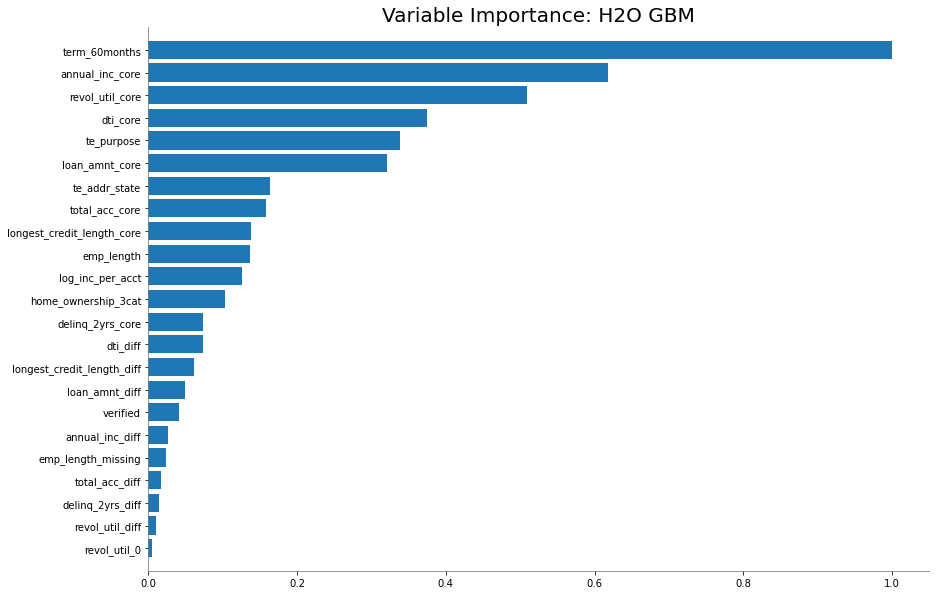

In [104]:
#> 変数重要度
final.leader.varimp_plot(23)

In [105]:
#> テストデータに対する結果の取得
perf3 = final.leader.model_performance(test_data=test)

In [106]:
print("--- AUC of Base Model ---")
print("AUC: train = {:.4f}, X-val = {:.4f}, test = {:.4f}".format(aml.leader.auc(train=True),
                                                                  aml.leader.auc(xval=True), 
                                                                  perf.auc()))
print("--- AUC of 中間 Model ---")
print("AUC: train = {:.4f}, X-val = {:.4f}, test = {:.4f}".format(check.leader.auc(train=True),
                                                                  check.leader.auc(xval=True), 
                                                                  perf2.auc()))
print("--- AUC of 最終 Model ---")
print("AUC: train = {:.4f}, X-val = {:.4f}, test = {:.4f}".format(final.leader.auc(train=True),
                                                                  final.leader.auc(xval=True), 
                                                                  perf3.auc()))

--- AUC of Base Model ---
AUC: train = 0.7258, X-val = 0.6812, test = 0.6835
--- AUC of 中間 Model ---
AUC: train = 0.7126, X-val = 0.6814, test = 0.6873
--- AUC of 最終 Model ---
AUC: train = 0.7141, X-val = 0.6814, test = 0.6866


In [108]:
h2o.cluster().shutdown()

H2O session _sid_9484 closed.
